### **Импорт необходимых библиотек**

In [387]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
import itertools
import random
sns.set(style="ticks")
%matplotlib inline 

### **Загрузка и анализ датасета**

Для проведения исследования возьмем [датасет LFW-People](https://www.kaggle.com/datasets/atulanandjha/lfwpeople) с сайта Kaggle \
Проанализируем его характеристики

In [388]:
data_folder = "data/"
# количество папок/классов/людей
len(os.listdir(data_folder))

5749

In [389]:
# количество картинок
images_count = sum([len(files) for r, d, files in os.walk(data_folder)])
print(images_count)

13233


Считываем все картинки из всех папок (1 папка - 1 имя, которое будем принимать за класс)

In [390]:
def get_images(data_folder, min_files_count = 0, max_files_count = 10000):
  names = []
  images = []
  classes_count = []

  for folder in os.listdir(data_folder):
    files = os.listdir(os.path.join(data_folder, folder))
    if (len(files) >= min_files_count):
      classes_count.append(len(files[:max_files_count]))
      for name in files[:max_files_count]:
          if name.find(".jpg") > -1 :
              img = cv2.imread(os.path.join(data_folder + folder, name))
              images.append(img)
              names.append(folder)

  return images, names, classes_count

In [391]:
images_full, names_full, classes_count_full = get_images(data_folder)

In [392]:
len(names_full), len(images_full), len(classes_count_full)

(13233, 13233, 5749)

Выведем названия всех классов (имена людей, которые определяем)

In [393]:
labels_full = np.unique(names_full)
labels_full, len(labels_full)

(array(['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', ..., 'Zumrati_Juma',
        'Zurab_Tsereteli', 'Zydrunas_Ilgauskas'], dtype='<U35'),
 5749)

Проверим дисбаланс классов

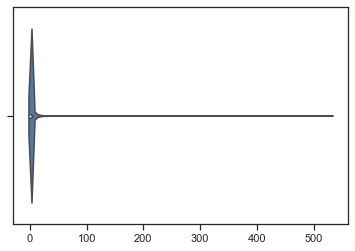

In [394]:
sns.violinplot(x=classes_count_full)
plt.show()

Как видим, дисбаланс классов достаточно большой, т.к. у большинства людей в датасете всего по 1 фотке, но есть личности, кол-во фотографий которых достигает нескольки сотен. Качество модели такого набора будет плохим: 
- Не получиться распознать человека с небольшим числом фотографий. 
- Если фотография одна, то даже разделение на тестовый и обучащий наборы будет не корректным. 
- Если количество фотографий одного класса будет превышать количество фотографий другого, то будет наблюдаться дисбаланс, один человек будет распознаваться хорошо, а другой нет. 
  
Чтобы все это исправить, будем работать только с классами, для которых количество фотографий будет больше 70ти и меньше 300 (значения были получены после нескольких тестовых попыток разделения).

In [395]:
images, names, classes_count = get_images(data_folder, 70, 300)

In [396]:
len(names), len(images), len(classes_count)

(1058, 1058, 7)

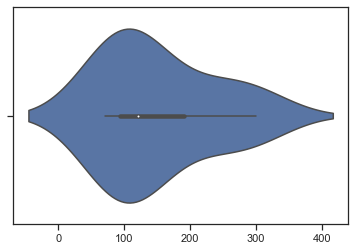

In [397]:
sns.violinplot(x=classes_count)
plt.show()

In [398]:
# все уникальные имена (классы)
labels = np.unique(names)
labels, len(labels)

(array(['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush',
        'Gerhard_Schroeder', 'Hugo_Chavez', 'Tony_Blair'], dtype='<U17'),
 7)

<BarContainer object of 7 artists>

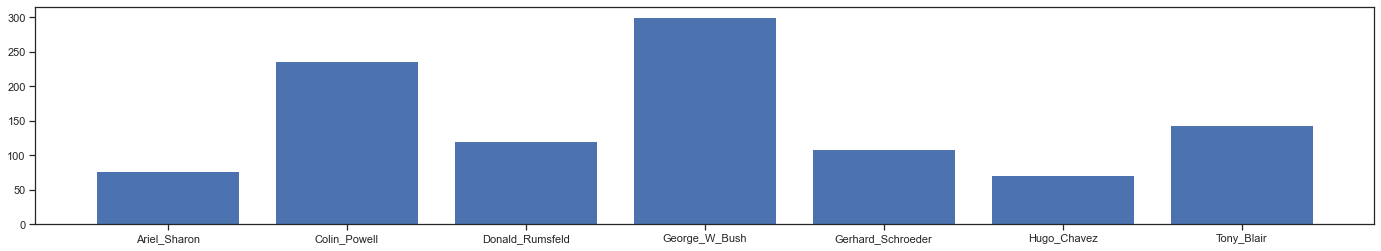

In [399]:
fig, ax = plt.subplots()
fig.set_figwidth(24)
ax.bar(labels, np.array(classes_count))

Дисбаланс классов устранен, папки с малым кол-вом фотографий рассмотрены не будут из-за недостатка информации для обучения. Теперь будет работать с полученными очищенными данными.

Просмотрим картинки одного из классов

In [400]:
def show_dataset(images_class, labels, photos_count):
    plt.figure(figsize=(18,photos_count))
    size_limit = len(images_class)
    k = 0
    for i in range(1,photos_count+1):
        if (k >= size_limit):
            k += 1
            continue
        plt.subplot(1,photos_count,i)
        try :
            plt.imshow(images_class[k][:,:,::-1])
        except :
            plt.imshow(images_class[k], cmap='gray')
        plt.title(labels[k], fontsize=10)
        plt.axis('off')
        plt.tight_layout()
        k += 1
    plt.show()

In [401]:
def show_photos_by_name(name, names, images, photos_count):
  example_ids = np.where(name==np.array(names))[0]
  example_images_class = images[example_ids[0] : example_ids[-1] + 1]

  for i in range(math.ceil(len(example_images_class)/photos_count)):
    show_dataset(example_images_class[photos_count*i:], names[example_ids[0] : example_ids[-1] + 1], photos_count)

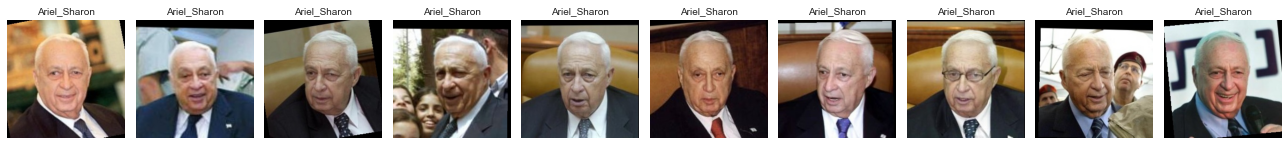

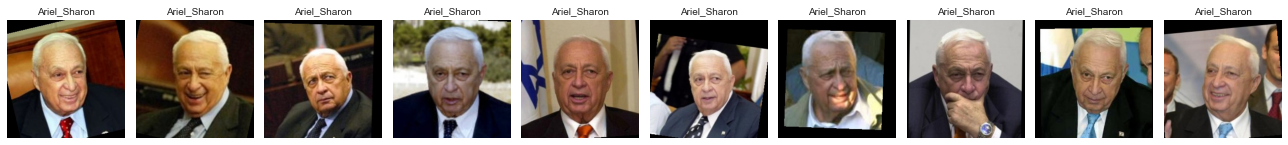

In [402]:
example_label = labels[0]
photos_count = 10

show_photos_by_name(example_label, names[:20], images[:20], photos_count)

### **Использование метода Виолы-Джноса для обнаружения лица**
Для определения лица на фото используем каскад библиотеки opencv: [каскады_opencv](https://github.com/opencv/opencv/tree/4.x/data/haarcascades)

In [403]:
face_cascade = cv2.CascadeClassifier('haarcascades\haarcascade_frontalface_default.xml')

Функция определения лица по фото, возвращает вырезанное из фото лицо, если оно было обнаружено

In [404]:
def detect_face(img, idx):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    
    try:
        x, y, w, h = faces[0]

        img = img[y:y+h, x:x+w]
        img = cv2.resize(img, (100, 100))
    except:
        img = None
    return img

Получаем массив определенных (вырезанных из фото) лиц

In [405]:
def cut_photos(images, names, start_point_for_name, logs = False):
  croped_images = []
  croped_names = []

  for i, img in enumerate(images):
    img = detect_face(img, i)
    if img is not None:
        croped_images.append(img)
        croped_names.append(names[start_point_for_name + i])
    else:
      if (logs == True):
        print('Фото ', i, ' представителя ', names[start_point_for_name + i], ' не было обнаружено')

  return croped_images, croped_names

In [406]:
example_ids = np.where(example_label==np.array(names))[0]
example_images_class = images[example_ids[0] : example_ids[-1] + 1]

example_croped_images, example_croped_names = cut_photos(example_images_class, names, example_ids[0], True)

Фото  16  представителя  Ariel_Sharon  не было обнаружено
Фото  30  представителя  Ariel_Sharon  не было обнаружено
Фото  35  представителя  Ariel_Sharon  не было обнаружено
Фото  38  представителя  Ariel_Sharon  не было обнаружено


In [407]:
len(example_images_class), len(example_croped_images), len(example_croped_names)

(77, 73, 73)

In [408]:
print('Процент обнаруженных фото: ', len(example_croped_images) / len(example_images_class) * 100, '%')

Процент обнаруженных фото:  94.8051948051948 %


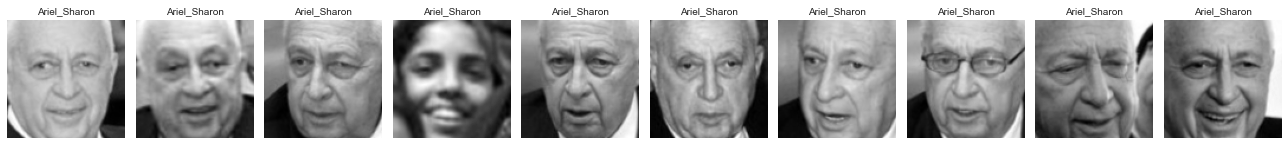

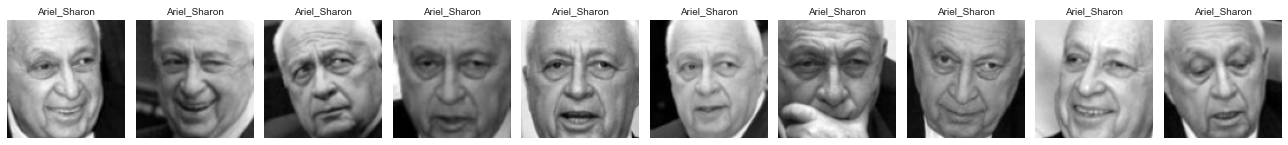

In [409]:
show_photos_by_name(example_label, example_croped_names[:20], example_croped_images[:20], photos_count)

Теперь посмотрим первые фото для всего набора

In [410]:
def show_photos(images, labels, photos_count_size, photos_count_in_line):
  rows_count = math.ceil(len(images[:photos_count_size])/photos_count_in_line)
  for i in range(rows_count):
    photos = images[photos_count_in_line*i:photos_count_size*(i+1)]
    labels_limited = labels[photos_count_in_line*i:photos_count_size*(i+1)]
    if (i + 1 == rows_count):
      photos = images[photos_count_in_line*i:photos_count_size]
      labels_limited = labels[photos_count_in_line*i:photos_count_size]
    show_dataset(photos, labels_limited, photos_count_in_line)

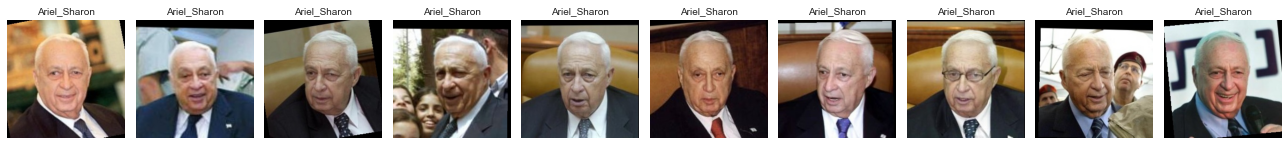

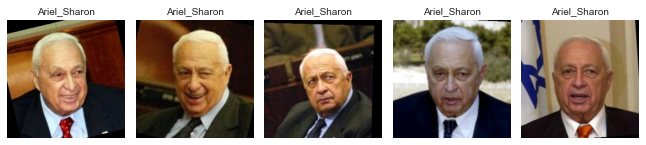

In [411]:
photos_count_size = 15
show_photos(images, names, photos_count_size, photos_count)

Определим и вырежем лица из всего набора

In [412]:
croped_images, croped_names = cut_photos(images, names, 0)

In [413]:
print('Процент обнаруженных фото: ', len(croped_images) / len(images) * 100, '%')

Процент обнаруженных фото:  97.16446124763705 %


### **Разделение выборки на обучающую и тестовую**

In [414]:
target = np.array([np.where(name == labels)[0][0] for name in croped_names])
print(target[:200])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [415]:
len(croped_images), len(croped_names), len(target)

(1028, 1028, 1028)

In [416]:
# объединение фотографий, имен и целевого признака в один массив, чтобы далее все вместе разделить
data = np.array([[croped_images[i], croped_names[i], target[i]] for i in range(len(croped_images))])

C:\Users\Pocht\AppData\Local\Temp\ipykernel_20964\2257608461.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([[croped_images[i], croped_names[i], target[i]] for i in range(len(croped_images))])


In [417]:
# разделение data на data_split(image+name) и target_split(class)
data_split = []
target_split = []
data_split_idx = data[0][2]
data_split.append([])
target_split.append([])
for d in data:
  if (d[2] != data_split_idx):
    data_split_idx = d[2]
    data_split.append([])
    target_split.append([])
  data_split[data_split_idx].append(d)
  target_split[data_split_idx].append(int(d[2]))

In [418]:
def get_column(data, idx):
  return [row[idx] for row in data]

In [419]:
images_train = []
names_train = []
target_train = []
images_test = []
names_test = []
target_test = []

for d in range(len(data_split)):
  X_train, X_test, y_train, y_test = train_test_split(data_split[d], target_split[d], test_size=0.3, random_state=42)
  images_train += get_column(X_train, 0)
  names_train += get_column(X_train, 1)
  target_train += get_column(X_train, 2)
  images_test += get_column(X_test, 0)
  names_test += get_column(X_test, 1)
  target_test += get_column(X_test, 2)

Объединение столбиков и перемешивание датасета

In [420]:
data_union_train = np.array([[images_train[i], names_train[i], target_train[i]] for i in range(len(images_train))])
data_union_test = np.array([[images_test[i], names_test[i], target_test[i]] for i in range(len(images_test))])

C:\Users\Pocht\AppData\Local\Temp\ipykernel_20964\3595319899.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_union_train = np.array([[images_train[i], names_train[i], target_train[i]] for i in range(len(images_train))])
C:\Users\Pocht\AppData\Local\Temp\ipykernel_20964\3595319899.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_union_test = np.array([[images_test[i], names_test[i], target_test[i]] for i in range(len(images_test))])


In [421]:
np.random.shuffle(data_union_train)
np.random.shuffle(data_union_test)

In [422]:
images_train_shuffled = get_column(data_union_train, 0)
names_train_shuffled = get_column(data_union_train, 1)
target_train_shuffled = get_column(data_union_train, 2)
images_test_shuffled = get_column(data_union_test, 0)
names_test_shuffled = get_column(data_union_test, 1)
target_test_shuffled = get_column(data_union_test, 2)

In [423]:
len(target_train_shuffled), len(images_train_shuffled), len(names_train_shuffled)

(716, 716, 716)

In [424]:
len(target_test_shuffled), len(images_test_shuffled), len(names_test_shuffled)

(312, 312, 312)

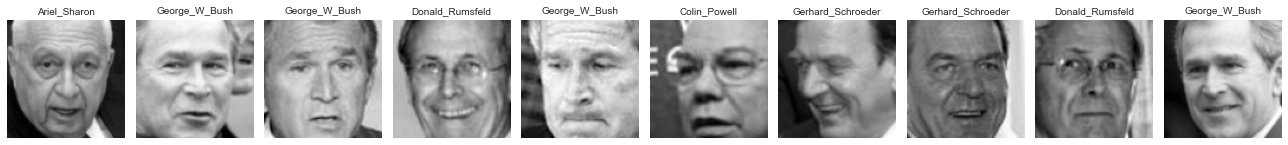

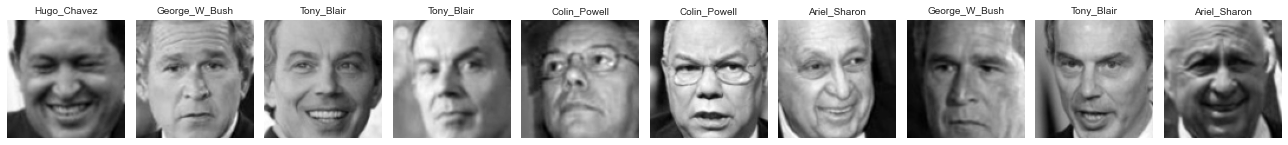

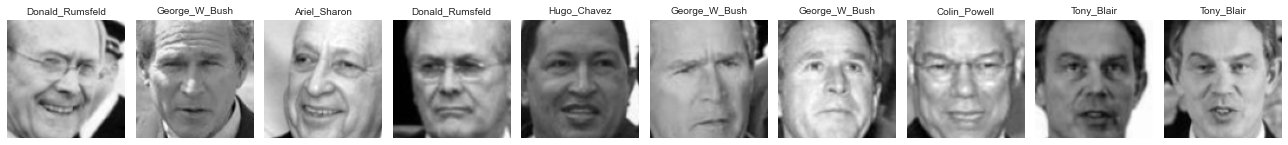

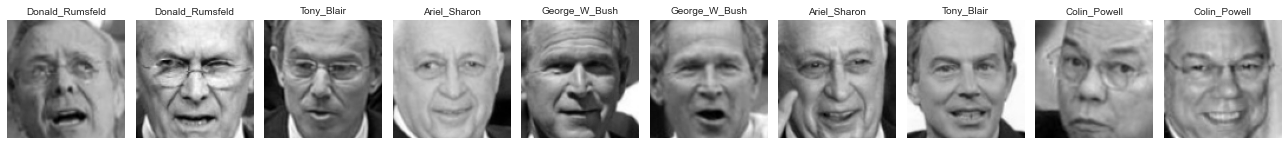

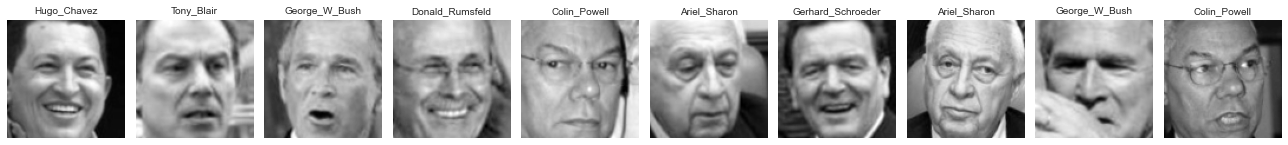

In [425]:
show_photos(images_test_shuffled, names_test_shuffled, 50, 10)

### **Распознавание лиц с помощью методов Eigen Faces, Fisher Faces, Local Binary Pattern Histograms**

In [426]:
model_eigenfaces = cv2.face.EigenFaceRecognizer_create()
model_fisherfaces = cv2.face.FisherFaceRecognizer_create()
model_lbph = cv2.face.LBPHFaceRecognizer_create()
models = [model_eigenfaces, model_fisherfaces, model_lbph]
models_names = ["model_eigenfaces", "model_fisherfaces", "model_lbph"]

Обучим модели:

In [427]:
for i in range(len(models)):
  models[i].train(images_train_shuffled, np.array(target_train_shuffled))
  models[i].save(models_names[i] + ".yml")
  models[i].read(models_names[i] + ".yml")

Распознавание лиц для всех моделей:

In [428]:
classes_real = []
classes_predict = []
images_real = []
images_predict = []
confidences = []

for i in range(len(models)):
  classes_real.append([])
  classes_predict.append([])
  images_real.append([])
  images_predict.append([])
  confidences.append([])

  for test_idx in range(len(names_test_shuffled)):
    idx, confidence = models[i].predict(images_test_shuffled[test_idx])

    classes_real[i].append(np.where(names_test_shuffled[test_idx] == labels)[0][0])
    classes_predict[i].append(idx)
    confidences[i].append(confidence)
    images_real[i].append(images_test_shuffled[test_idx])
    images_predict[i].append(images_test_shuffled[idx])

Распознанное имя:  Ariel_Sharon
Реальное имя:  Ariel_Sharon
Confidence:  83.700856122778


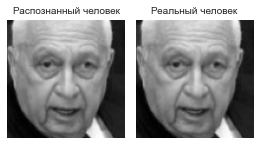

Распознанное имя:  George_W_Bush
Реальное имя:  George_W_Bush
Confidence:  100.02266132588427


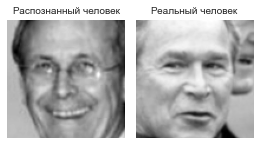

Распознанное имя:  George_W_Bush
Реальное имя:  George_W_Bush
Confidence:  57.563370024660585


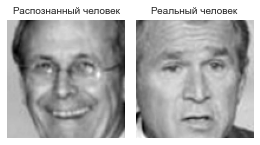

Распознанное имя:  Donald_Rumsfeld
Реальное имя:  Donald_Rumsfeld
Confidence:  22.420038790347323


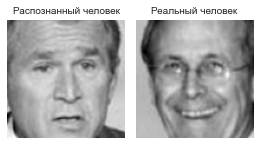

Распознанное имя:  Tony_Blair
Реальное имя:  George_W_Bush
Confidence:  70.3983089335857


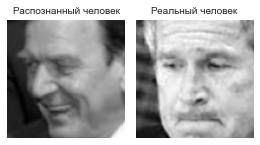

In [429]:
number_of_show_model = 1

for i in range(5):
  print("Распознанное имя: ", labels[classes_predict[number_of_show_model][i]])
  print("Реальное имя: ", labels[classes_real[number_of_show_model][i]])
  print("Confidence: ", confidences[number_of_show_model][i])

  show_photos([images_predict[number_of_show_model][i], images_real[number_of_show_model][i]], ['Распознанный человек', 'Реальный человек'], 2, 10)

In [430]:
for i in range(len(models)):
  print("Model ", models_names[i])
  print("Accuracy:", accuracy_score(classes_real[i], classes_predict[i]))
  print("Balanced accuracy:", balanced_accuracy_score(classes_real[i], classes_predict[i]), '\n')

Model  model_eigenfaces
Accuracy: 0.4326923076923077
Balanced accuracy: 0.3635685249521189 

Model  model_fisherfaces
Accuracy: 0.7243589743589743
Balanced accuracy: 0.6543894101186883 

Model  model_lbph
Accuracy: 0.8717948717948718
Balanced accuracy: 0.8487385095331123 



In [431]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.tight_layout()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # plt.colorbar()
    plt.ylabel('Реальное имя')
    plt.xlabel('Распознанное имя')

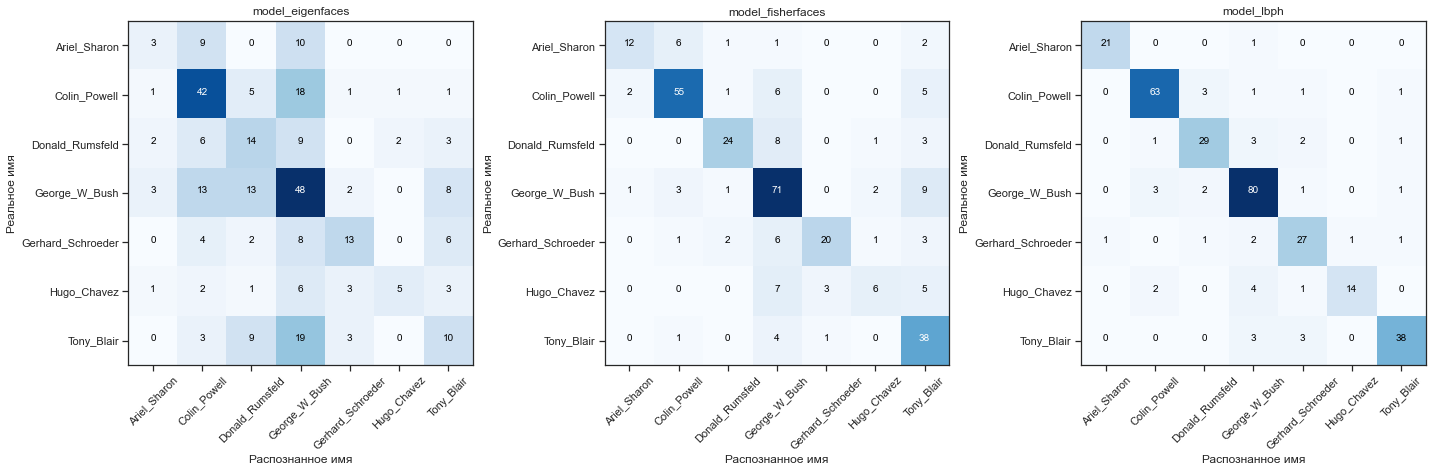

In [432]:
plt.figure(figsize=(20,10))

for i in range(len(models)):
  cnf_matrix = confusion_matrix(classes_real[i], classes_predict[i])
  plt.subplot(1,len(models),i+1)
  plot_confusion_matrix(cnf_matrix, classes=labels,normalize=False,title=models_names[i])

plt.show()

По матрицам видно, что лучше всего

In [433]:
for i in range(len(models)):
  print("Model ", models_names[i])
  print(classification_report(classes_real[i], classes_predict[i], target_names=labels))

Model  model_eigenfaces
                   precision    recall  f1-score   support

     Ariel_Sharon       0.30      0.14      0.19        22
     Colin_Powell       0.53      0.61      0.57        69
  Donald_Rumsfeld       0.32      0.39      0.35        36
    George_W_Bush       0.41      0.55      0.47        87
Gerhard_Schroeder       0.59      0.39      0.47        33
      Hugo_Chavez       0.62      0.24      0.34        21
       Tony_Blair       0.32      0.23      0.27        44

         accuracy                           0.43       312
        macro avg       0.44      0.36      0.38       312
     weighted avg       0.44      0.43      0.42       312

Model  model_fisherfaces
                   precision    recall  f1-score   support

     Ariel_Sharon       0.80      0.55      0.65        22
     Colin_Powell       0.83      0.80      0.81        69
  Donald_Rumsfeld       0.83      0.67      0.74        36
    George_W_Bush       0.69      0.82      0.75        87
Ger

In [434]:
len(classes_real), len(classes_predict), len(names_test_shuffled), len(labels)

(3, 3, 312, 7)

Вывод: модель LBPH обладает наилучшим качеством распознавания лиц по фотографиям